### Conway-Maxwell-Poisson distribution

I came across a distribution recently for {inter,over}-dispersion and heavy tail count data. The [Conway-Maxwell-Poisson distribution](https://en.wikipedia.org/wiki/Conway%E2%80%93Maxwell%E2%80%93Poisson_distribution).

I think may be it can model the count data for this challenge better. In this notebook, the implementation of the log partition function is an approximation and the implementation of the random number gnerator follow the implementation in the package [Numerics](https://github.com/mathnet/mathnet-numerics/blob/master/src/Numerics/Distributions/ConwayMaxwellPoisson.cs) in C#.

In [2]:
%matplotlib inline

import numpy as np
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm
from pymc3.distributions.discrete import Discrete, bound, draw_values, generate_samples

theano.config.compute_test_value = "ignore"
np.random.seed(507884)
sns.set_context("talk")
sns.set_style("darkgrid")
sns.set_palette("Set2", 20)

### Generate some fake data

In [3]:
n,d = 1000, 4
X = np.abs(np.random.randn(n,d))
y = np.round(X.sum(axis=1)).astype(int)

In [4]:
pd.Series(y).describe()

count    1000.000000
mean        3.192000
std         1.257266
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
dtype: float64

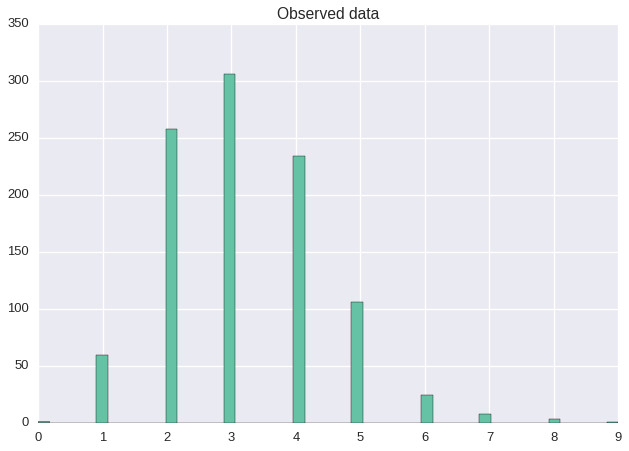

In [10]:
plt.hist(y, bins=50)
plt.title("Observed data")

### The COM-Poisson model

In [5]:
class CMPoisson(Discrete):
    def __init__(self, lamda, nu, *args, **kwargs):
        super(CMPoisson, self).__init__(*args, **kwargs)
        self.lamda = lamda
        self.alpha = tt.power(lamda, 1/nu)
        self.nu = nu
    
    def logp(self, value):
        lamda = self.lamda
        nu = self.nu
        alpha = self.alpha
        pi = tt.constant(np.pi)
        
        log_Z = nu * alpha - ((nu-1)/2)*tt.log(2*pi*alpha) - 0.5*tt.log(nu)
        return bound(value * tt.log(lamda) - nu * tt.gammaln(value+1) - log_Z, lamda > 0, nu > 0)
    
    def _random(self, lamda, nu, size=None):
        size = size or 1
        
        nu = np.atleast_1d(nu)
        alpha = np.atleast_1d(np.power(lamda, 1/nu))
        Z = np.exp(nu * alpha) / ((2 * np.pi * alpha)**((nu-1)/2) * np.sqrt(nu))
        
        U = np.random.uniform(low=0, high=1, size=size)
        values = np.empty(size, dtype=int)
        
        for i in range(U.shape[0]):
            p = 1/Z
            cdf = p
            k = 0
            u = U[i]
            
            while any(u > cdf):
                k += 1
                p =  (p * lamda)/k**nu
                cdf += p
            
            values[i] = k
        return values
    
    def random(self, point=None, size=None, repeat=None):
        lamda,nu = draw_values([self.lamda, self.nu], point=point)
        return generate_samples(self._random, lamda, nu, dist_shape=self.shape, size=size)

In [6]:
CMPoisson.dist(lamda=3, nu=2).random(size=10)

array([1, 1, 2, 0, 2, 2, 2, 1, 1, 2])

### Build The model

In [7]:
cmp_model = pm.Model()

with cmp_model:
    alpha = pm.Normal("alpha", mu=1)
    beta = pm.Normal("beta", mu=1, shape=d)
    lam = alpha + tt.dot(X,beta)
    nu = pm.HalfNormal("nu", sd=10)
    
    like = CMPoisson("like", lamda=lam, nu=nu, observed=y)

Applied log-transform to nu and added transformed nu_log to model.


In [8]:
with cmp_model:
    step= pm.NUTS()
    cmp_trace = pm.sample(500, step=step)

 [-----------------100%-----------------] 500 of 500 complete in 192.8 sec

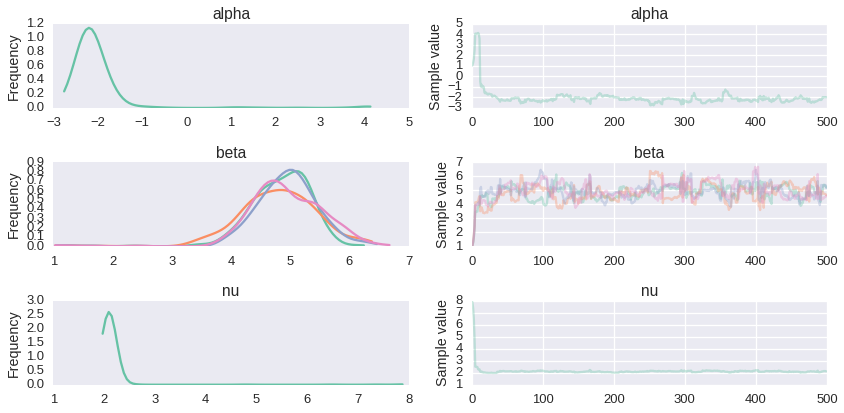

In [9]:
_ = pm.traceplot(cmp_trace)

### Make prediction

In [15]:
ppc = pm.sample_ppc(trace=cmp_trace, samples=1, model=cmp_model)["like"][0]

In [12]:
def predict(X):
    alpha = cmp_trace["alpha"].mean(0)
    beta = cmp_trace["beta"].mean(0)
    nu = cmp_trace["nu"].mean(0)
    
    lam = alpha + np.dot(X, beta)
    
    return CMPoisson.dist(lamda=lam, nu=nu).random()

def score(true, pred):
    
    def rmsle(resp, pred):
        """Root Mean Squared Logarithm Error"""
        n = resp.shape[0]
        return np.sqrt(np.sum(np.square(np.log(pred + 1) - np.log(resp + 1)))/n)
    
    return 1 - rmsle(true, pred)

In [13]:
pred = predict(X)

In [14]:
score(y, pred)

0.42452095913584242

In [16]:
score(y, ppc)

0.37200824889126449

#### References

Galit Shmuel et al. [A useful distribution for fitting discrete data: revival of the Conway–Maxwell–Poisson distribution](www.galitshmueli.com/system/files/JRSS-COM-Poisson.pdf)

Burc ̧in S ̧ims ̧ek and Satish Iyengar [Approximating the Conway-Maxwell-Poisson normalizing constant](http://www.doiserbia.nb.rs/img/doi/0354-5180/2016/0354-51801604953S.pdf)